# Victor 2D: combining diffusion and linear advection / linear convection

### Diffusion equation in finite differences

We saw that 2D diffusion equation can be represented by algebraic expressions that are easily solved using finite differences. In 2D Cartesian coordinates, the diffusion equation is:

$$\frac{\partial T}{\partial t} = \alpha \left [ \frac{\partial^2 T}{\partial x^2} +  \frac{\partial^2 T}{\partial y^2} \right ] $$

Assuming that $\Delta x = \Delta y = s$

$$T_{i,j}^{k+1} = T_{i,j}^{k} + \frac{\Delta t \alpha}{s^2} 
\left [ T_{i,j-1}^k + T_{i-1,j}^k  - 4T_{i,j}^k + T_{i+1,j}^k + T_{i,j+1}^k   \right ] $$

The maximum time step depends on the grid spacing and the diffusivity:

$$\Delta t_{max} = \frac{\Delta x^2 \Delta y^2 }{2 \alpha (\Delta x^2 + \Delta y^2)} = \frac{s^2}{4 \alpha}$$


### Advection in finite differences

Linear convection is the process of transporting material (gas, water, particles) in an externally applied field. For example, tephra particles are transported in a wind field. This is an advection problem if one assumes the tephra particles have no impact on the wind field and diffusion of tephra particles is neglected. Advection is sometimes referred to as forced convection. Both phrases mean that the velocity field is determined independently of the partcles / fluid being transported.

Although the concept is simple, it is useful to write out the differential equation for advection:
$$\frac{\partial T}{\partial t} + w  \frac{\partial T}{\partial x} +  v \frac{\partial T}{\partial y} = 0$$

In this case we are updating the concentration $T$, or the temperature in the following examples. For example, consider a packet of hot air being blown in a windfield, or a "packet" of water transported in a groundwater transport problem. 

Assuming that $\Delta x = \Delta y = s$

$$T_{i,j}^{k+1} = T_{i,j}^{k} - w \frac{\Delta t}{s} 
\left [ T_{i,j}^k - T_{i-1,j}^k \right ] - v \frac{\Delta t}{s} 
\left [ T_{i,j}^k - T_{i,j-1}^k \right ]$$

In this case, 

$$\Delta t_{max} = \frac{s}{2 \times \text{max}(w,v)} $$

This discretization assumes that $w$ and $v$ are positive. That is, the updated value in the cell depends on the values in the cells that are "up wind". The solution does not work if the values of $w$ or $v$ are negative. That is, the cells downwind from cell($i,j$) do not contain information about what will flow into that cell in the next step.


### Simplified script for solution to the 2D advection equation

In [20]:
import numpy as np
import matplotlib.pyplot as plt

In [21]:
# 2D advection finite difference
# this equation only works if w_x and v_y are positive
def one_time_step_2D_linear_convection(u0, u, w_x, v_y, dt, dx, dy):
    u[1:, 1:] = u0[1:, 1:] - w_x * dt * (u0[1:, 1:] - u0[1:, :-1])/dx - v_y * dt * (u0[1:, 1:] - u0[:-1,1:])/dy
    u0 = u.copy()
    return u0, u

In [25]:
#run a simple test

#specify model space
w = h = 5000.
# intervals in x-, y- directions, m
dx = dy = 10
# set the wind speed
w_x = 10 # m/s
v_y = 10 # m/s

Tcool, Thot = 200, 1200

nx, ny = int(w/dx), int(h/dy)
dt = dx/(2*max(w_x, v_y))

u0 = Tcool*np.ones((nx, ny))

u = u0.copy()

u0[200:300, 200:300] = Thot


### Here is the starting condition

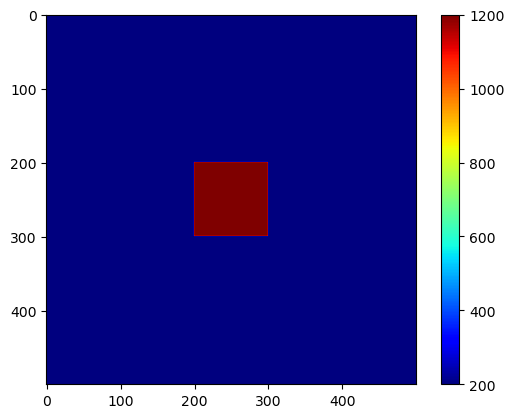

time elapsed =  0 s


In [26]:
plt.imshow(u0, cmap='jet', vmin=Tcool,vmax=Thot)
plt.colorbar()
plt.show()
print ("time elapsed = ", 0, "s")


### Run through time

In [27]:
# Number of timesteps
nsteps = 300

for m in range(nsteps):
    u0, u = one_time_step_2D_linear_convection(u0, u, w_x, v_y, dt, dx, dy)


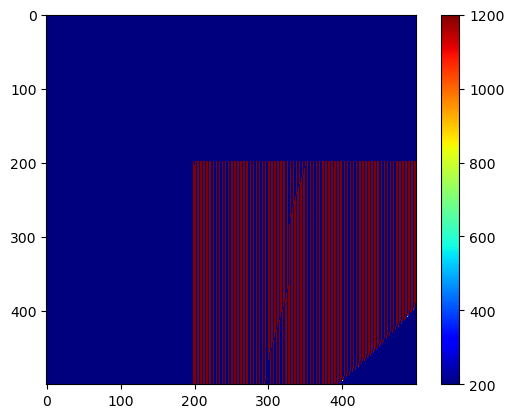

time elapsed =  150.0 s


In [28]:
plt.imshow(u0, cmap='jet', vmin=Tcool,vmax=Thot)
plt.colorbar()
plt.show()
print ("time elapsed = ", nsteps*dt, "s")


The results make sense generally because the starting box has moved (advected) to the SE in positive $w, v$ directions. Note that there is diffusion of the box as a result of the numerical approximation of the advection. This is referred to as numerical diffusion. It is an artifact of the numerical approximation to the advection equation. Try adjusting the size of the grid ($w,h$) and the cell spacing ($dx, dy$) to see the change in numerical diffusion as a function of the elapsed time ($nsteps \times dt$). Although roughly correct, this method of solving the advection equation is generally unstable, for reasons developed in the following. So do not use this simple approach. What happens when you change one or both wind speeds to be negative numbers?

### Solve for the problem of wind direction

This solution is quite close to the previous solution but solves the problem of wind direction (positive or negative) in a straightforward way

$$T_i^{k+1} = T_i^k - \frac{\Delta t}{\Delta x} \left [ F_{i+1/2}^k - F_{i-1/2}^k\right ] $$
where:
$$F_{i + 1/2}^k = \frac{w_x}{2}(T_{i+1}^k + T_{i}^k) - \frac{| w_x |}{2} (T_{i+1}^k - T_{i}^k)$$
$$F_{i - 1/2}^k = \frac{w_x}{2}(T_{i-1}^k + T_{i}^k) - \frac{| w_x |}{2} (T_{i-1}^k - T_{i}^k)$$
Working through the algebra:

If $w_x > 0$:
$$T_i^{k+1} = T_i^k - \frac{w_x \Delta t}{\Delta x}\left [ T_{i}^k - T_{i-1}^k\right ] $$

If $w_x < 0$:
$$T_i^{k+1} = T_i^k + \frac{w_x \Delta t}{\Delta x}\left [ T_{i+1}^k - T_{i}^k\right ] $$

If $w_x = 0$:
$$T_i^{k+1} = T_i^k $$


In [29]:
# 2D advection finite difference
# this equation only works if w_x and v_y are positive or negative
def one_time_step_1D_linear_convection_staggered(u0, u, w_x, dt, dx):
  
    if w_x > 0:
        u[1:] = u0[1:] - dt/dx * (u0[1:] - u0[:-1]) 
    elif w_x < 0:
        u[:-1] = u0[:-1] + dt/dx * (u0[1:] - u0[:-1])
    else:
        u0[:] = u[:]
   
    u0 = u.copy()
    return u0, u

In [33]:
#run a simple test

#specify model space
w = 5000.
# intervals in x-, y- directions, m
dx = 10
# set the wind speed
w_x = 10 # m/s


Tcool, Thot = 200, 1200

nx = int(w/dx)
dt = dx/(2*abs(w_x))

u0 = Tcool*np.ones((nx))
u = u0.copy()

u0[250:300] = Thot

x = np.linspace(-w/2*dx,w/2*dx, nx)
u_start = u0.copy()

In [34]:
# Number of timesteps
nsteps = 3000

for m in range(nsteps):
    u0, u = one_time_step_1D_linear_convection_staggered(u0, u, w_x, dt, dx)

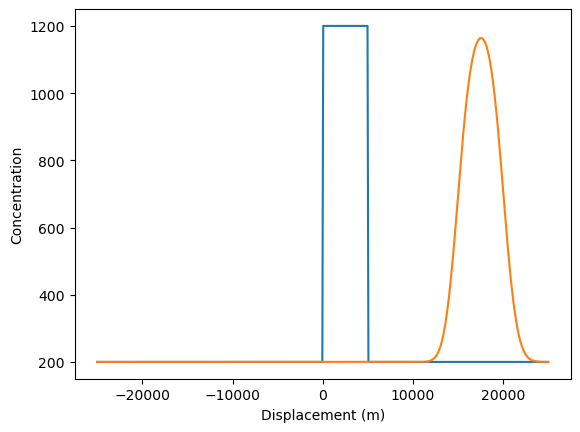

windspeed =  10
time step =  0.5 s
elapsed time =  1500.0 s


In [35]:
plt.plot(x, u_start)
plt.plot(x,u0)
plt.xlabel("Displacement (m)")
plt.ylabel("Concentration")
plt.show()
print("windspeed = ", w_x)
print("time step = ", dt, "s")
print("elapsed time = ", dt*nsteps, "s")

###  two step Lax - Wendroff scheme for the 1D advection equation

The previous example solves the problem of wind direction, but the numerical diffusion remains a problem! The Lax-Wendroff method solves this problem using a two step process. The finite difference approximation to the 1D advection equation becomes:

$$T_{i}^{k+1} = T_{i}^{k}  - \alpha \left [\frac{1}{2} (T_{i+ 1 }^{k} + T_{i}^{k})
 - \frac{1}{2} \alpha (T_{i+ 1 }^{k} - T_{i}^{k}) 
- \frac{1}{2} (T_{i}^{k} + T_{i-1}^{k}) 
+ \frac{1}{2} \alpha (T_{i}^{k} - T_{i-1}^{k}) 
\right ] $$

where:

$$\alpha = \frac{w \Delta t}{\Delta x} $$

and the method is numerically stable for

$$\Delta t \le \frac{\Delta x}{| w |} $$

In [11]:
def LaxWendroff1Dadvection(u0, u, w_x, dt, dx):
    alpha = w_x*dt/dx
    u[1:-1] = u0[1:-1]- alpha*(1/2*(u0[2:]+u0[1:-1])
                             - 1/2 * alpha*(u0[2:]-u0[1:-1])
                             - 1/2* (u0[1:-1]+u0[:-2]) 
                              + 1/2 * alpha * (u0[1:-1]-u0[:-2]))
    u0 = u.copy()
    return u0, u

In [12]:
#run a simple test

#specify model space
w = 5000.
# intervals in x-, y- directions, m
dx = 1
# set the wind speed
w_x = -10 # m/s


Tcool, Thot = 200, 1200

nx = int(w/dx)
dt = dx/(abs(w_x))

u0 = Tcool*np.ones((nx))
u = u0.copy()

u0[2500:3000] = Thot

x = np.linspace(-w/2*dx,w/2*dx, nx)
u_start = u0.copy()

In [13]:
# Number of timesteps
nsteps = 2000

for m in range(nsteps):
    u0, u = LaxWendroff1Dadvection(u0, u, w_x, dt, dx)

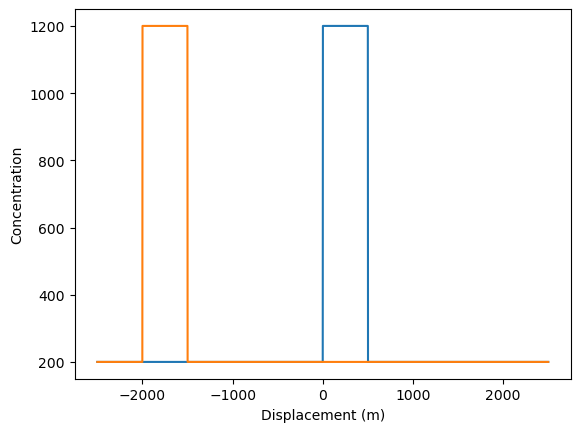

windspeed =  -10
time step =  0.1 s
elapsed time =  200.0 s


In [14]:
plt.plot(x, u_start)
plt.plot(x,u0)
plt.xlabel("Displacement (m)")
plt.ylabel("Concentration")
plt.show()
print("windspeed = ", w_x)
print("time step = ", dt, "s")
print("elapsed time = ", dt*nsteps, "s")

### Go to 2D with the two step Lax - Wendroff scheme for the advection equation



In [15]:
def LaxWendroff2Dadvection(u0, u, w_x, v_y, dt, dx, dy):
    a_x = w_x*dt/dx
    a_y = v_y*dt/dy
    
    term_x = np.zeros_like(u0)
    term_y = np.zeros_like(u0)
    
    term_y[1:-1,1:-1]=a_y*(1/2*(u0[2:,1:-1] + u0[1:-1, 1:-1])
                           -1/2*a_y*(u0[2:,1:-1] - u0[1:-1, 1:-1])
                           -1/2*(u0[1:-1, 1:-1] + u0[:-2, 1:-1])
                           + 1/2*a_y*(u0[1:-1, 1:-1] - u0[:-2, 1:-1]))
    
    term_x[1:-1,1:-1]=a_x*(1/2*(u0[1:-1, 2:] + u0[1:-1, 1:-1])
                           -1/2*a_x*(u0[1:-1, 2:] - u0[1:-1, 1:-1])
                           -1/2*(u0[1:-1, 1:-1] + u0[1:-1, :-2])
                           + 1/2*a_x*(u0[1:-1, 1:-1] - u0[1:-1,:-2]))
   
    u[1:-1,1:-1] = u0[1:-1,1:-1] - term_x[1:-1,1:-1] - term_y[1:-1,1:-1]
    
    u0 = u.copy()
    
    return u0, u

In [16]:
#run a simple test

#specify model space
w = h = 5000.
# intervals in x-, y- directions, m
dx = dy = 10
# set the wind speed
w_x = -5 # m/s
v_y = -5 # m/s

Tcool, Thot = 200, 1200

nx, ny = int(w/dx), int(h/dy)
dt = dx/(25*abs(w_x))
print (dt)
u0 = Tcool*np.ones((nx, ny))
u = u0.copy()

u0[int(nx/2)-10:int(nx/2)+10, int(ny/2) - 10: int(ny/2) + 10] = Thot


0.08


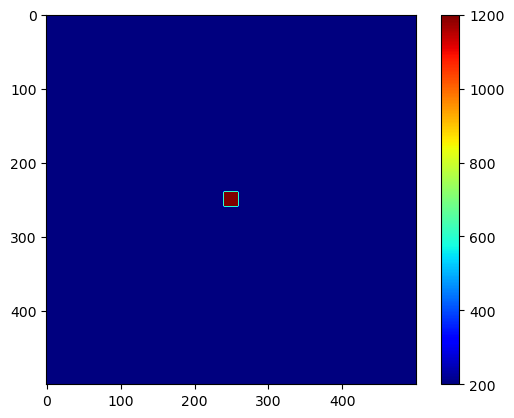

time elapsed =  0 s


In [17]:
plt.imshow(u0, cmap='jet', vmin=Tcool,vmax=Thot)
plt.colorbar()
plt.show()
print ("time elapsed = ", 0, "s")


In [18]:
# Number of timesteps
nsteps = 5000
for m in range(nsteps):
    u0, u = LaxWendroff2Dadvection(u0, u, w_x, v_y, dt, dx, dy)
    u0[int(nx/2)-10:int(nx/2)+10, int(ny/2) - 10: int(ny/2) + 10] = Thot

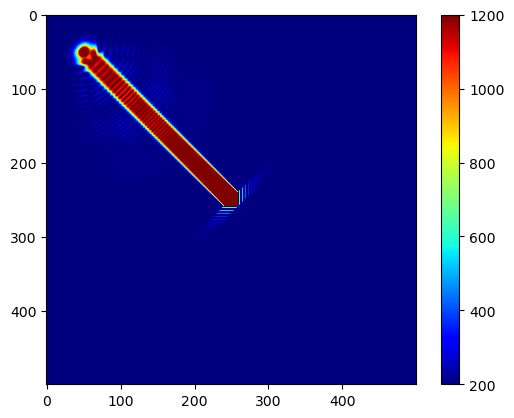

time elapsed =  400.0 s


In [19]:
plt.imshow(u0, cmap='jet', vmin=Tcool,vmax=Thot)
plt.colorbar()
plt.show()
print ("time elapsed = ", nsteps*dt, "s")


Hmmm, still a bit unstable, but not SO BAD.